In [ ]:
!wget https://frenzy86.s3.eu-west-2.amazonaws.com/python/nlp/yelp_labelled.txt
!wget https://frenzy86.s3.eu-west-2.amazonaws.com/python/nlp/amazon_cells_labelled.txt
!wget https://frenzy86.s3.eu-west-2.amazonaws.com/python/nlp/imdb_labelled.txt

In [2]:
import pandas as pd

In [3]:
import warnings
warnings.filterwarnings('ignore')

In [4]:
yelp_ds = pd.read_csv('yelp_labelled.txt', sep ='\t', header = None, names = ['reviews', 'sentiment'])
amazon_ds = pd.read_csv('amazon_cells_labelled.txt', sep ='\t', header = None, names = ['reviews', 'sentiment'])
imdb_ds = pd.read_csv('imdb_labelled.txt', sep ='\t', header = None, names = ['reviews', 'sentiment'])

In [10]:
#https://pandas.pydata.org/pandas-docs/version/0.23.4/merging.html
df = pd.concat([yelp_ds, amazon_ds, imdb_ds], ignore_index=True)  #o reset index

In [15]:
df.shape

(2748, 2)

In [11]:
df['reviews'].to_list()

['Wow... Loved this place.',
 'Crust is not good.',
 'Not tasty and the texture was just nasty.',
 'Stopped by during the late May bank holiday off Rick Steve recommendation and loved it.',
 'The selection on the menu was great and so were the prices.',
 'Now I am getting angry and I want my damn pho.',
 "Honeslty it didn't taste THAT fresh.)",
 'The potatoes were like rubber and you could tell they had been made up ahead of time being kept under a warmer.',
 'The fries were great too.',
 'A great touch.',
 'Service was very prompt.',
 'Would not go back.',
 'The cashier had no care what so ever on what I had to say it still ended up being wayyy overpriced.',
 'I tried the Cape Cod ravoli, chicken,with cranberry...mmmm!',
 'I was disgusted because I was pretty sure that was human hair.',
 'I was shocked because no signs indicate cash only.',
 'Highly recommended.',
 'Waitress was a little slow in service.',
 'This place is not worth your time, let alone Vegas.',
 'did not like at all.'

In [12]:
df['reviews'].isnull().sum()

0

#Data Cleaning

In [13]:
import re

def clean_special_patterns(text):
    """Remove special patterns - email, url, date etc."""
    html_regex = re.compile(r"<.*?>")
    email_regex = re.compile(r"[\w.-]+@[\w.-]+")
    url_regex = re.compile(r"(http|www)[^\s]+")
    date_regex = re.compile(r"[\d]{2,4}[ -/:]*[\d]{2,4}([ -/:]*[\d]{2,4})?") # a way to match date
    new_line = re.compile(r"/(\r\n)+|\r+|\n+|\t+/")
    number = re.compile(r"[\d+]")
    under = re.compile(r"[^a-zA-Z0-9:$-,%.?!]+")
    simbols = re.compile(r"[^\w\s/'/`]")
    spaces = re.compile(r"\s{2,}")
    remove_singlelett= re.compile(r"(^| ).( |$)")

    ## remove
    text = text.lower()
    text = number.sub(" ", text)
    text = html_regex.sub(" ", text)
    text = url_regex.sub(" ", text)
    text = email_regex.sub(" ", text)
    text = date_regex.sub(" ", text)
    text = new_line.sub(" ", text)
    text = under.sub(" ", text)
    text = simbols.sub(" ", text)
    text = spaces.sub(" ", text)
    text = text.replace("`", "'")
    text = remove_singlelett.sub("",text)
    return text

#Cleaning AllinOne

In [14]:
#Applichiamo la funzione di cleaning all in once
df['reviews'] = df['reviews'].apply(clean_special_patterns)
df

,reviews,sentiment
0,wow loved this place,1
1,crust is not good,0
2,not tasty and the texture was just nasty,0
3,stopped by during the late may bank holiday of...,1
4,the selection on the menu was great and so wer...,1
...,...,...
2743,just got bored watching jessice lange take her...,0
2744,unfortunately any virtue in this film's produc...,0
2745,inword it is embarrassing,0
2746,exceptionally bad,0


In [16]:
df['reviews'] = df['reviews'].replace({'negative':0,'positive':1})
df = df[['reviews','sentiment']]
df

,reviews,sentiment
0,wow loved this place,1
1,crust is not good,0
2,not tasty and the texture was just nasty,0
3,stopped by during the late may bank holiday of...,1
4,the selection on the menu was great and so wer...,1
...,...,...
2743,just got bored watching jessice lange take her...,0
2744,unfortunately any virtue in this film's produc...,0
2745,inword it is embarrassing,0
2746,exceptionally bad,0


In [17]:
df['sentiment'].value_counts()

1    1386
0    1362
Name: sentiment, dtype: int64

#STOPWORDS + LEMMATIZATION Function with SpaCy

In [18]:
## Spacy Custom Pipeline
import numpy as np
import multiprocessing as mp

import string
import spacy 
from sklearn.base import TransformerMixin, BaseEstimator


nlp = spacy.load("en_core_web_sm")

class TextPreprocessor(BaseEstimator, TransformerMixin):
    def __init__(self,
                 nlp = nlp,
                 n_jobs=1):
        """
        Text preprocessing transformer includes steps:
            1. Punctuation removal
            2. Stop words removal
            3. Lemmatization

        nlp  - spacy model
        n_jobs - parallel jobs to run
        """
        self.nlp = nlp
        self.n_jobs = n_jobs

    def fit(self, X, y=None):
        return self

    def transform(self, X, *_):
        X_copy = X.copy()

        partitions = 1
        cores = mp.cpu_count()
        if self.n_jobs <= -1:
            partitions = cores
        elif self.n_jobs <= 0:
            return X_copy.apply(self._preprocess_text)
        else:
            partitions = min(self.n_jobs, cores)

        data_split = np.array_split(X_copy, partitions)
        pool = mp.Pool(cores)
        data = pd.concat(pool.map(self._preprocess_part, data_split))
        pool.close()
        pool.join()

        return data

    def _preprocess_part(self, part):
        return part.apply(self._preprocess_text)

    def _remove_punct(self, doc):
        return (t for t in doc if t.text not in string.punctuation)

    def _remove_stop_words(self, doc):
        return (t for t in doc if not t.is_stop)

    def _lemmatize(self, doc):
        return ' '.join(t.lemma_ for t in doc)

    def _preprocess_text(self, text):
        doc = self.nlp(text)
        removed_punct = self._remove_punct(doc)
        removed_stop_words = self._remove_stop_words(removed_punct)
        return self._lemmatize(removed_stop_words)

In [19]:
#takes 2 min of processing
text_preprocess = TextPreprocessor(n_jobs=-1)._preprocess_text
#df["text"][0:10].apply(text_preprocess)
df['reviews'] = df['reviews'].apply(text_preprocess)
df

,reviews,sentiment
0,wow love place,1
1,crust good,0
2,tasty texture nasty,0
3,stop late bank holiday rick steve recommendati...,1
4,selection menu great price,1
...,...,...
2743,get bore watch jessice lange clothe,0
2744,unfortunately virtue film production work lose...,0
2745,inword embarrassing,0
2746,exceptionally bad,0


#EDA

In [20]:
cleaned = ' '.join(df['reviews'].to_list())

(-0.5, 799.5, 399.5, -0.5)

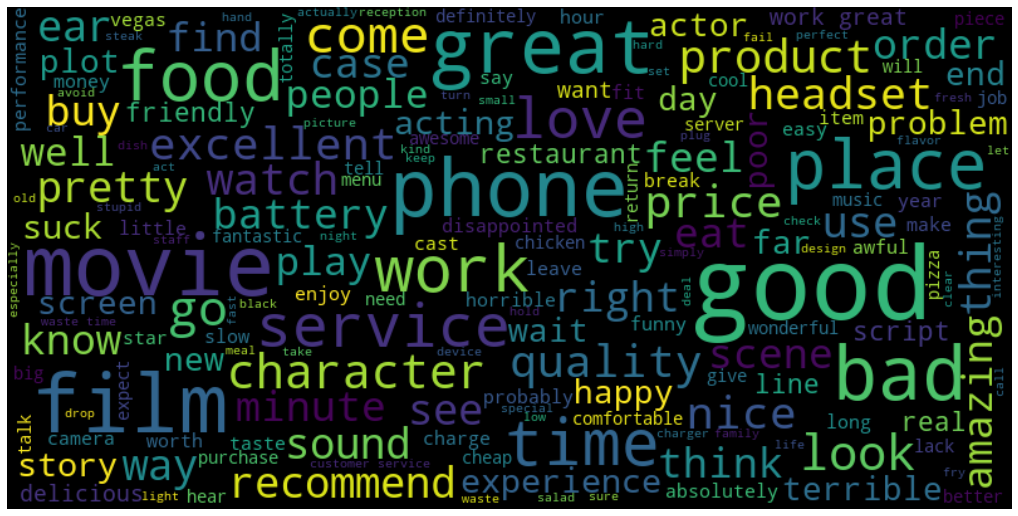

In [21]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

wordcloud = WordCloud(background_color = 'black', width = 800, height = 400,
                      max_words = 180, contour_width = 3,
                      max_font_size = 80, contour_color = 'steelblue',
                      random_state = 667)

wordcloud.generate(cleaned)

plt.figure(figsize=(18,10))
plt.imshow(wordcloud, interpolation = 'bilinear')
plt.axis("off")

#Bag of Words

In [22]:
X = df['reviews'] # FEATURES
y = df['sentiment'] # TARGET

In [23]:
from sklearn.feature_extraction.text import CountVectorizer

vectorizer = CountVectorizer(max_features=1500, min_df=5, max_df=0.7)

X_ = vectorizer.fit_transform(X).toarray()
X_

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]])

#TF-IDF

In [24]:
from sklearn.feature_extraction.text import TfidfTransformer

tfidfconverter = TfidfTransformer()
X_ = tfidfconverter.fit_transform(X_).toarray()
X_

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [25]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

X_train, X_test, y_train, y_test = train_test_split(X_, y,
                                                    test_size=0.25, 
                                                    random_state=667
                                                    )

In [26]:
labels = ['Negative', 'Positive']

##RandomForest

In [27]:
from sklearn.ensemble import RandomForestClassifier

classifier = RandomForestClassifier(n_estimators=1000, random_state=667,max_depth=5)
classifier.fit(X_train, y_train) 

RandomForestClassifier(max_depth=5, n_estimators=1000, random_state=667)

In [28]:
# accuracy score on the test data
y_pred = classifier.predict(X_test)
test_data_accuracy = accuracy_score(y_test, y_pred)
print('Accuracy score of the test data : ', test_data_accuracy)

Accuracy score of the test data :  0.710334788937409


Text(69.0, 0.5, 'Actual')

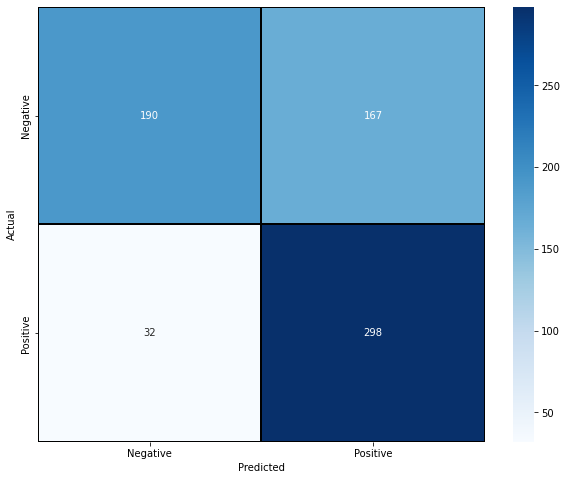

In [29]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix 

cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize = (10,8))
sns.heatmap(cm,cmap= "Blues", 
            linecolor = 'black', 
            linewidth = 1, 
            annot = True, 
            fmt='', 
            xticklabels = labels, 
            yticklabels = labels)

plt.xlabel("Predicted")
plt.ylabel("Actual")

In [30]:
from sklearn.metrics import classification_report
#labels = ['class1', 'class2']
print(classification_report(y_test, y_pred, target_names=labels))

              precision    recall  f1-score   support

    Negative       0.86      0.53      0.66       357
    Positive       0.64      0.90      0.75       330

    accuracy                           0.71       687
   macro avg       0.75      0.72      0.70       687
weighted avg       0.75      0.71      0.70       687



In [31]:
!pip install plot-metric --quiet

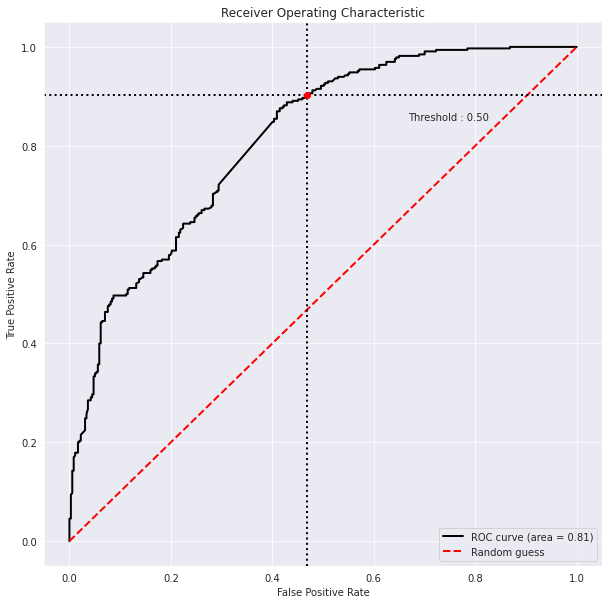

In [32]:
from plot_metric.functions import BinaryClassification
y_pred_proba = classifier.predict_proba(X_test)[::,1]

#labels = ['class1', 'class2']
bc = BinaryClassification(y_test, y_pred_proba, labels=labels)

# Figures
plt.figure(figsize=(10,10))
bc.plot_roc_curve();

##MultinomialNB

In [33]:
from sklearn.naive_bayes import MultinomialNB
classifier = MultinomialNB()
classifier.fit(X_train, y_train) 

MultinomialNB()

In [34]:
# accuracy score on the test data
y_pred = classifier.predict(X_test)
test_data_accuracy = accuracy_score(y_test,y_pred)
print('Accuracy score of the test data : ', test_data_accuracy)

Accuracy score of the test data :  0.7409024745269287


Text(69.0, 0.5, 'Actual')

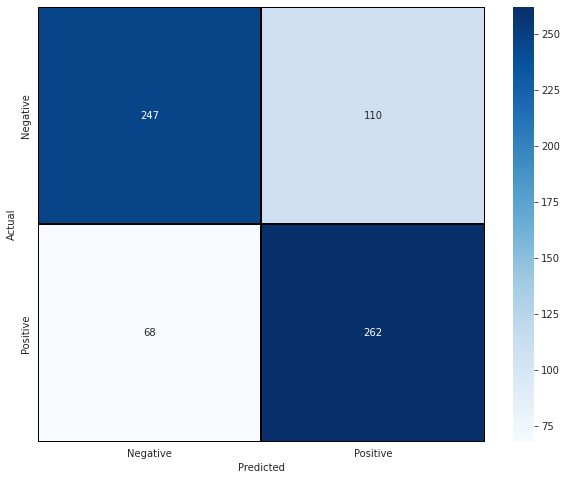

In [35]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix 

cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize = (10,8))
sns.heatmap(cm,cmap= "Blues", 
            linecolor = 'black', 
            linewidth = 1, 
            annot = True, 
            fmt='', 
            xticklabels = labels, 
            yticklabels = labels)

plt.xlabel("Predicted")
plt.ylabel("Actual")

In [36]:
from sklearn.metrics import classification_report
#labels = ['class1', 'class2']
print(classification_report(y_test, y_pred, target_names=labels))

              precision    recall  f1-score   support

    Negative       0.78      0.69      0.74       357
    Positive       0.70      0.79      0.75       330

    accuracy                           0.74       687
   macro avg       0.74      0.74      0.74       687
weighted avg       0.75      0.74      0.74       687



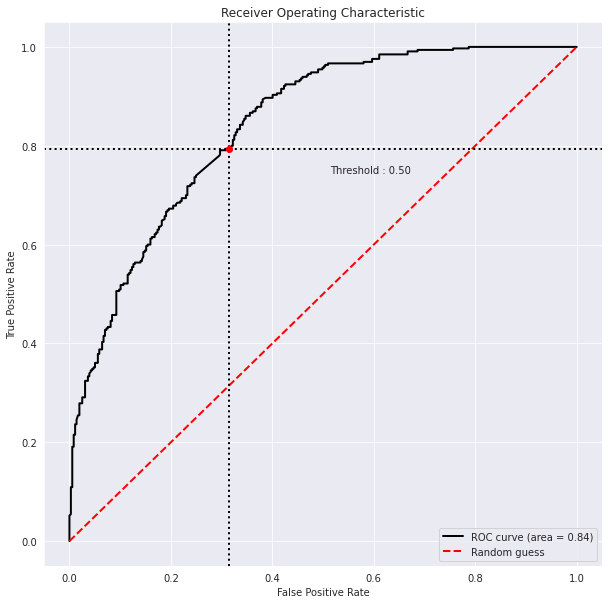

In [37]:
from plot_metric.functions import BinaryClassification
y_pred_proba = classifier.predict_proba(X_test)[::,1]

#labels = ['class1', 'class2']
bc = BinaryClassification(y_test, y_pred_proba, labels=labels)

# Figures
plt.figure(figsize=(10,10))
bc.plot_roc_curve();

##SGD Classifier

In [38]:
# accuracy score on the test data
from sklearn.linear_model import SGDClassifier

classifier = SGDClassifier(loss='log', penalty='l2',alpha=1e-3, random_state=667, max_iter=5, tol=None)
classifier.fit(X_train, y_train) 

y_pred = classifier.predict(X_test)
test_data_accuracy = accuracy_score(y_test, y_pred)
print('Accuracy score of the test data : ', test_data_accuracy)

Accuracy score of the test data :  0.7336244541484717


Text(69.0, 0.5, 'Actual')

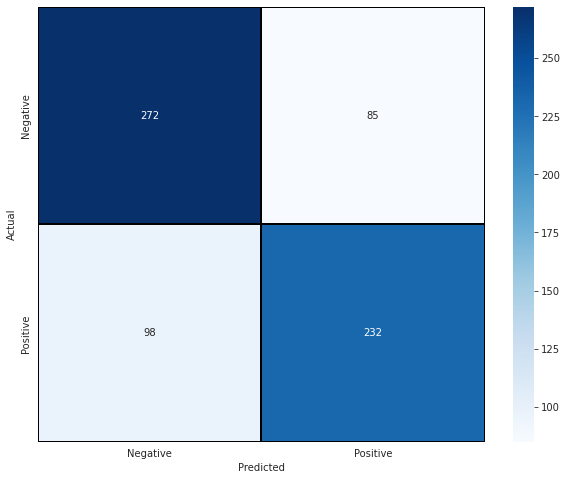

In [39]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix 

cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize = (10,8))
sns.heatmap(cm,cmap= "Blues", 
            linecolor = 'black', 
            linewidth = 1, 
            annot = True, 
            fmt='', 
            xticklabels = labels, 
            yticklabels = labels)

plt.xlabel("Predicted")
plt.ylabel("Actual")

In [40]:
from sklearn.metrics import classification_report
#labels = ['class1', 'class2']
print(classification_report(y_test, y_pred, target_names=labels))

              precision    recall  f1-score   support

    Negative       0.74      0.76      0.75       357
    Positive       0.73      0.70      0.72       330

    accuracy                           0.73       687
   macro avg       0.73      0.73      0.73       687
weighted avg       0.73      0.73      0.73       687



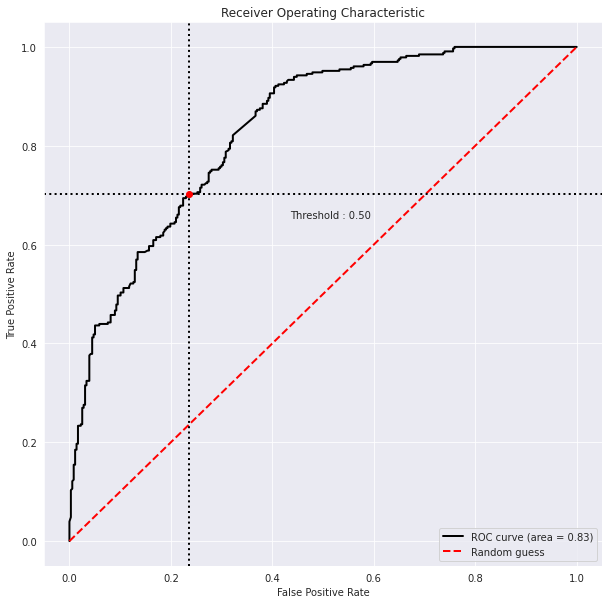

In [41]:
from plot_metric.functions import BinaryClassification
y_pred_proba = classifier.predict_proba(X_test)[::,1]

#labels = ['class1', 'class2']
bc = BinaryClassification(y_test, y_pred_proba, labels=labels)

# Figures
plt.figure(figsize=(10,10))
bc.plot_roc_curve();

#Pipeline

In [42]:
X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    test_size=0.25, 
                                                    random_state=667
                                                    )

RICORDA: il classifier va cambiato a seconda di quale ha il risultato migliore!!!!

In [43]:
from sklearn.pipeline import Pipeline

text_preprocess = TextPreprocessor(n_jobs=-1)
bow = CountVectorizer(max_features=1500, min_df=5, max_df=0.7)
tfidf = TfidfTransformer()
classifier = MultinomialNB()

pipe = Pipeline([
                ('lemma_stop_rem',text_preprocess),
                ('bow',bow),
                ('tfidf',tfidf),
                ('clf',classifier),
                ])

pipe.fit(X_train, y_train)

predicted = pipe.predict(X_test)
test_data_accuracy = accuracy_score(y_test, predicted)
print('Accuracy score of the test data : ', test_data_accuracy)

Accuracy score of the test data :  0.7321688500727802


In [44]:
test = pd.Series({'text':"I love you"})

In [45]:
prediction = pipe.predict(test)
print(prediction[0])

if (prediction[0] == 0):
  print('Negative')
else:
  print('Positive')

1
Positive


In [46]:
import joblib

joblib.dump(pipe,'pipeline_classifier_SpaCy.pkl')

['pipeline_classifier_SpaCy.pkl']